In [ ]:
!pip install astroNN

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from astroNN.datasets import load_galaxy10
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [ ]:
images, labels = load_galaxy10()

In [ ]:
# # To train the model faster, resize images to (64, 64)
# (Note: If you want to train it even faster, resize to (32,32))
images = tf.image.resize(images, (32, 32)).numpy()

In [ ]:
x_train, x_test, _, _ = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
# If the above takes too long, you could try it out with CIFAR-10 instead
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# Normalize the training images to range [-1,1]
x_train = 2*x_train / 255. - 1

## Generator architecture definition

### This is the architecture we use

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, channels):
    super(PositionalEncoding, self).__init__()
    self.channels = channels

  def call(self, inputs):

    # Step 1: Inputs will have to be of shape (Batch, 1, 1, 1)

    # Step 2: Compute inverse frequency based on channel indices

    # Step 3: Compute sine and cosine embeddings and concatenate them
    pos_sin = ...
    pos_cos = ...
    pos_enc = ...

    return pos_enc

In [ ]:
class ConvolutionalBlock(tf.keras.layers.Layer):
  def __init__(self, channels1, channels2, use_res_connect=False):
    super(ConvolutionalBlock, self).__init__()

    self.use_res_connect = use_res_connect

    self.conv1 = tf.keras.layers.Conv2D(channels1, 3, strides=1, padding='same')
    self.norm1 = tf.keras.layers.LayerNormalization()
    self.act = tf.nn.gelu
    self.conv2 = tf.keras.layers.Conv2D(channels2, 3, strides=1, padding='same')
    self.norm2 = tf.keras.layers.LayerNormalization()


  def call(self, inputs):

    x = self.conv1(inputs)
    x = self.norm1(x)
    x = self.act(x)
    x = self.conv2(x)
    x = self.norm2(x)

    if self.use_res_connect:
      x = self.act(x + inputs)

    return x

In [ ]:
class DownSample(tf.keras.layers.Layer):
  def __init__(self, channels, embedding_dim=128):
    super(DownSample, self).__init__()
    self.channels = channels

    self.down = tf.keras.layers.Conv2D(channels, 3, strides=2, padding='same')
    self.conv1 = ConvolutionalBlock(2*channels, 2*channels, use_res_connect=False)
    self.conv2 = ConvolutionalBlock(2*channels, 2*channels, use_res_connect=True)
    self.embedding = tf.keras.layers.Dense(2*channels, activation=tf.nn.silu)

  def call(self, inputs):

    x, t = inputs
    x = self.down(x)
    x = self.conv1(x)
    x = self.conv2(x)

    emb = self.embedding(t)
    emb = tf.reshape(emb, [-1, 1, 1, x.shape[-1]])

    return x + emb

In [ ]:
class UpSample(tf.keras.layers.Layer):
  def __init__(self, channels, embedding_dim=128):
    super(UpSample, self).__init__()
    self.channels = channels

    self.up = tf.keras.layers.Conv2DTranspose(channels, 3, strides=2, padding='same')
    self.conv1 = ConvolutionalBlock(channels//2, channels//2, use_res_connect=False)
    self.conv2 = ConvolutionalBlock(channels//2, channels//2, use_res_connect=True)
    self.concat = tf.keras.layers.Concatenate()

    self.embedding = tf.keras.layers.Dense(channels//2, activation=tf.nn.silu)

  def call(self, inputs):

    x, skip_x, t = inputs
    x = self.up(x)
    x = self.concat([x, skip_x])
    x = self.conv1(x)
    x = self.conv2(x)

    emb = self.embedding(t)
    emb = tf.reshape(emb, [-1, 1, 1, x.shape[-1]])

    return x + emb

In [ ]:
class DiffusionModel(tf.keras.layers.Layer):
  def __init__(self, channels=16, time_embed=128):
    super(DiffusionModel, self).__init__()
    self.channels = channels
    self.time_embed = time_embed

    self.conv1 = ConvolutionalBlock(channels, channels*2)
    self.down1 = DownSample(channels*2)
    self.down2 = DownSample(channels*4)
    self.down3 = DownSample(channels*8)

    self.bottle1 = ConvolutionalBlock(channels*8, channels*8, use_res_connect=False)
    self.bottle2 = ConvolutionalBlock(channels*8, channels*8, use_res_connect=True)

    self.up1 = UpSample(channels*8)
    self.up2 = UpSample(channels*4)
    self.up3 = UpSample(channels*2)

    self.conv3 = tf.keras.layers.Conv2D(3, 3, strides=1, padding='same')

    self.pos_embedding = PositionalEncoding(channels)


  def call(self, inputs):

    x, t = inputs
    t = self.pos_embedding(t)

    x1 = self.conv1(x)

    # Step 1: Apply the downsampling layers
    x2 = ...
    x3 = ...
    x4 = ...

    x4 = self.bottle1(x4)
    x4 = self.bottle2(x4)

    # Step 2: Apply the upsampling layers
    x = ...
    x = ...
    x = ...

    x = self.conv3(x)

    return x

In [ ]:
# Simple U-net diffusion model
def define_diffusion_model(img_size, summary=False):

  inp = tf.keras.layers.Input(shape=(img_size[0], img_size[1], img_size[2]))
  t = tf.keras.layers.Input(shape=(1,))

  diffusion = DiffusionModel()

  out = diffusion([inp, t])
  model = tf.keras.Model([inp, t], out)

  if summary:
    model.summary()

  return model

## Define the custom diffusion model

In [ ]:
class GenerateSamples(tf.keras.callbacks.Callback):
  def __init__(self, diffusion, every_nth_epoch):
    # Set the model to be used
    self.diffusion = diffusion
    self.every_nth_epoch = every_nth_epoch

  def on_epoch_end(self, epoch, logs=None):

    if epoch % self.every_nth_epoch == 0:
      print('\n Generate sample images...')
      imgs = self.diffusion.sample(3)

      plt.figure(figsize=(15,5))
      for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(imgs[i,])
        plt.axis('off')
      plt.show();

In [ ]:
class Diffusion(tf.keras.Model):
  def __init__(self, num_steps, img_size=64, beta_schedule='linear'):
    super(Diffusion, self).__init__()

    self.num_steps = num_steps
    self.img_size = img_size

    if beta_schedule == 'linear':
      self.beta = self.linear_noise_schedule()
    elif beta_schedule == 'cosine':
      self.beta = tf.clip_by_value(self.cosine_noise_schedule(), 0, 0.999)

    self.alpha = 1 - self.beta
    self.alpha_hat = tf.math.cumprod(self.alpha, axis=0)

    self.model = define_diffusion_model(img_size)

  # Create the noise schedule
  def linear_noise_schedule(self):
    beta_start = 0.0001
    beta_end = 0.02

    # Step 1: Implement a linear noise schedule
    betas = ...
    return betas


  def cosine_noise_schedule(self, s=0.008):
    t = tf.linspace(0, self.num_steps, self.num_steps+1)
    alpha_hat = tf.cos(((t/self.num_steps) + s)/(1 + s)*np.pi* 0.5) ** 2
    alpha_hat = alpha_hat / alpha_hat[0]
    betas = 1 - (alpha_hat[1:] / alpha_hat[:-1])
    return tf.cast(betas, tf.float32)

  # Add noise to the images
  def forward_model(self, x, t):

    eps = tf.random.normal(shape=x.shape)

    # Step 1: Retrieve `alpha_hat` and `1 - alpha_hat` for timestep `t`
    sqrt_alpha_hat = ...
    sqrt_one_minus_alpha_hat = ...

    # Step 2: Implement the forward diffusion process
    # Hint: Think about how `x_mean` should scale the original image
    x_mean = ...
    x_noise = ...

    return x_mean + x_noise, eps

  def sample_timesteps(self, num_imgs):
    return tf.random.uniform((num_imgs,), 0, self.num_steps, dtype=tf.int32)

  def call(self, inputs):
    imgs, t = inputs
    out = self.model([imgs, t])
    return out

  # Sample from the model
  def sample(self, num_imgs):

    x = tf.random.normal((num_imgs, self.img_size[0], self.img_size[1], self.img_size[2]))

    for i in tqdm(reversed(range(self.num_steps)), position=0):

      t = tf.convert_to_tensor([i]*num_imgs)

      # Step 1: Predict noise using the trained model
      predicted_noise = ...

      alpha = tf.reshape(tf.gather(self.alpha, t), (-1, 1, 1, 1))

      # Step 2: Compute alpha_hat and beta for timestep t
      alpha_hat = ...
      beta = ...

      # Step 3: Compute next step in reverse diffusion
      if i > 0:
        noise = ...
      else:
        noise = ...

      x = 1 / tf.sqrt(alpha) * (x - ((1 - alpha) /  tf.sqrt(1 - alpha_hat)) * predicted_noise) + tf.sqrt(beta) * noise

    x = (tf.clip_by_value(x, -1.0, 1.0) + 1)/2
    x = tf.cast(x*255, tf.uint8)
    return x

  # Train the model
  @tf.function
  def train_step(self, batch):

    batch_size = batch.shape[0]
    t = self.sample_timesteps(batch_size)
    batch_corrupted, noise = self.forward_model(batch, t)

    with tf.GradientTape() as tape:

      # Predict the noise
      predicted_noise = self.model([batch_corrupted, t], training=True)

      # Compute the loss
      loss = self.compute_loss(y=noise, y_pred=predicted_noise)

    # Compute the gradients
    gradients = tape.gradient(loss, self.trainable_variables)

    # Update the weights
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.compiled_metrics.update_state(noise, predicted_noise)
    return {m.name: m.result() for m in self.metrics}

## Train the model

In [ ]:
model = Diffusion(num_steps=500, img_size=x_train.shape[1:], beta_schedule='linear')

In [ ]:
# Call the model once to get the model summary
noise = model([x_train[:10], np.reshape(np.random.randint(0, 300, 10),(-1,1))])
model.summary()

Model: "diffusion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 64, 64, 3)           │       4,196,387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,196,387 (16.01 MB)

 Trainable params: 4,196,387 (16.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss=tf.keras.losses.MeanSquaredError())

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```



499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0139
 Generate sample images...


500it [01:23,  5.98it/s]


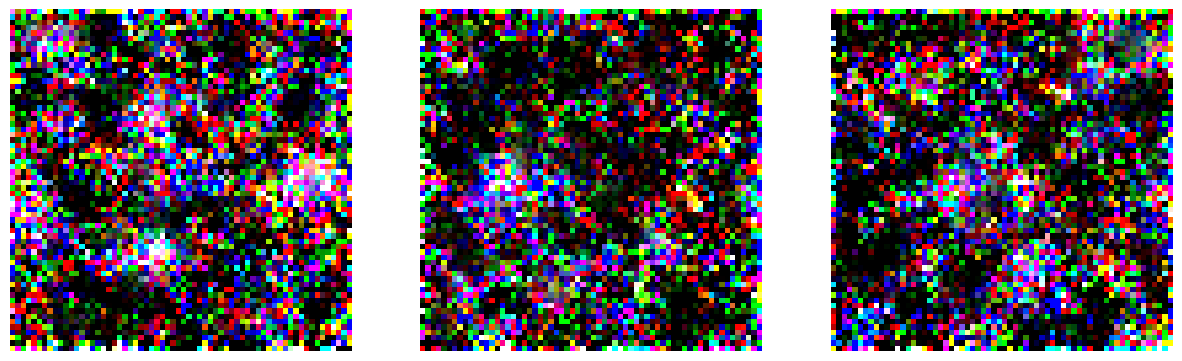

500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 210ms/step - loss: 0.0139
Epoch 2/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 6.4610e-04
Epoch 3/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 1.9919e-04
Epoch 4/500
338/500 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 1.0019e-04

In [ ]:
hist = model.fit(x_train[:10000], epochs=500, batch_size=20,
                 callbacks=[GenerateSamples(model, 20)])

## Plotting

In [ ]:
# Let's illustrate the forward diffusion process
img = 2*x_test[12]/255. - 1
diffused, _ = model.forward_model(img, 0)

diffused = []
for i in range(500):
  diffused.append(model.forward_model(img, i)[0][0])

diffused = np.array(diffused)

diffused = 2*(diffused - np.reshape(diffused.min(axis=(1,2,3)), (-1,1,1,1)) )/ (np.reshape(diffused.max(axis=(1,2,3)), (-1,1,1,1)) - np.reshape(diffused.min(axis=(1,2,3)), (-1,1,1,1))) - 1.0
diffused = 255*(diffused+1)/2


plt.figure(figsize=(15,5))
count = 0
for i in [0, 10, 20, 50, 100, 499]:
  count += 1
  plt.subplot(1,6,count)
  plt.imshow(diffused[i].astype(np.uint8));
  plt.title(f'Step: {i}')
  plt.axis('off')
plt.savefig('diffusionExample.png')

In [ ]:
# Sample from the model to generate some images
img = model.sample(16)

In [ ]:
# Check the pixel distribution (to make sure it looks reasonable, i.e. not
# too many saturated pixels)
plt.hist(img.numpy().flatten(), 20);

In [ ]:
# Generated images
plt.figure(figsize=(15,15))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(img[i,])
  plt.axis('off')
plt.savefig('generatedImages.png')

In [ ]:
# True images (for comparison purposes)
plt.figure(figsize=(15,15))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(x_test[i,].astype('uint8'))
  plt.axis('off')
plt.savefig('trueImages.png')